In [ ]:
%pip install gdown


In [ ]:

import gdown

gdown.download(url="https://drive.google.com/uc?id=15GE8umgsscRoAfQJ_bRmbRHzqv9kcBDu", output="Grayscale.zip", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=15GE8umgsscRoAfQJ_bRmbRHzqv9kcBDu
To: /content/Grayscale.zip
100%|██████████| 4.98M/4.98M [00:00<00:00, 239MB/s]


'Grayscale.zip'

In [ ]:
!mkdir dataset

In [ ]:
!unzip Grayscale.zip -d dataset

Archive:  Grayscale.zip
   creating: dataset/Grayscale/
  inflating: dataset/__MACOSX/._Grayscale  
  inflating: dataset/Grayscale/IDRiD_118.jpg  
  inflating: dataset/__MACOSX/Grayscale/._IDRiD_118.jpg  
  inflating: dataset/Grayscale/IDRiD_130.jpg  
  inflating: dataset/__MACOSX/Grayscale/._IDRiD_130.jpg  
  inflating: dataset/Grayscale/IDRiD_124.jpg  
  inflating: dataset/__MACOSX/Grayscale/._IDRiD_124.jpg  
  inflating: dataset/Grayscale/IDRiD_332.jpg  
  inflating: dataset/__MACOSX/Grayscale/._IDRiD_332.jpg  
  inflating: dataset/Grayscale/IDRiD_326.jpg  
  inflating: dataset/__MACOSX/Grayscale/._IDRiD_326.jpg  
  inflating: dataset/Grayscale/IDRiD_246.jpg  
  inflating: dataset/__MACOSX/Grayscale/._IDRiD_246.jpg  
  inflating: dataset/Grayscale/IDRiD_252.jpg  
  inflating: dataset/__MACOSX/Grayscale/._IDRiD_252.jpg  
  inflating: dataset/Grayscale/IDRiD_285.jpg  
  inflating: dataset/__MACOSX/Grayscale/._IDRiD_285.jpg  
  inflating: dataset/Grayscale/IDRiD_291.jpg  
  inflating: 

In [ ]:
import os
import csv
import shutil

# Path to the folder containing images
images_folder = '/content/dataset/Grayscale'

csv_file = '/content/a. IDRiD_Disease Grading_Training Labels.csv'

# Create folders for grade 0 and other grades
grade_0_folder = os.path.join(images_folder, '0')
other_grades_folder = os.path.join(images_folder, '1')
os.makedirs(grade_0_folder, exist_ok=True)
os.makedirs(other_grades_folder, exist_ok=True)

with open(csv_file, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        grade = row['Retinopathy grade']
        image_name = row['Image name'] + '.jpg'
        source_path = os.path.join(images_folder, image_name)
        if os.path.exists(source_path):
            if grade == '0':
                destination_path = os.path.join(grade_0_folder, image_name)
            else:
                destination_path = os.path.join(other_grades_folder, image_name)
            shutil.move(source_path, destination_path)
        else:
            print(f"{image_name} not found.")


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.image as mpimg
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.applications import VGG16,ResNet101V2,VGG19,MobileNetV2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
import tensorflow.keras.layers as lyrs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

root="/content/dataset/Grayscale"
IMG_SIZE=224

In [ ]:
#View Random Image
def view_random_image(root_path,folder,class_folder):
    path=root_path+'/'+folder+'/'+class_folder
    rand=random.choice(os.listdir(path))
    random_image=mpimg.imread(path+'/'+rand)
    plt.imshow(random_image)
    plt.title("File Name: " + rand)

#Pre-processing the Image
def pre_process_image(path, image_shape=224, channels=3, norm_factor=255.):
    '''Pre-Processing the Image before sending it to the model'''
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=channels)
    img = tf.image.resize(img, size = (image_shape, image_shape))
    img = tf.expand_dims(img, axis=0)
    img = img/norm_factor
    return img

#Testing Image Classification Model
def random_tester(root_path, classes, model, class_type="binary"):
    '''Random Class Folder Selection'''
    path=root_path
    class_folder=random.choice(os.listdir(path))

    '''Random File Selection'''
    folder_path=path+'/'+class_folder+'/'
    rand=random.choice(os.listdir(folder_path))
    file_path=folder_path+'/'+rand
    random_image=mpimg.imread(file_path)

    '''Prediction'''
    predicted_value=model.predict(pre_process_image(file_path))
    if(class_type=="binary"):
        predicted_label=classes[custom_rounder(predicted_value)]
    else:
        index=tf.math.round(predicted_value).numpy()
        index=np.argmax(index)
        predicted_label=classes[index]

    '''Visualize'''
    plt.imshow(random_image)
    plt.title("Prediction:" + predicted_label +"\n" +"True class: "+ class_folder)
    plt.show()

#Plot Loss and Accuracy curve for the given Model
def loss_curve_plot(df):
    """ Dataframe (df) is history of the fit of the NN model
    The df consists of train and validation fit data
    """
    history = df.history
    val_accuracy = history["val_accuracy"]
    val_loss = history["val_loss"]
    train_accuracy = history["accuracy"]
    train_loss = history["loss"]

    """Accuracy Plot"""
    plt.plot(train_accuracy, label="Train Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy Curves")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

    """Loss Plot"""
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.title("Loss Curves")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

#Confusion Matrix for Classification
def confusion_matrix_plot(y_true, y_pred, figsize=(30,30)):
    """"Confusion Matrix for true values and predicted values"""
    cm = metrics.confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)
    plt.figure(figsize = figsize)
    sns.heatmap(cm, annot=True, cmap="crest")

#Supervised Learning Meterics
def supervised_metrics(y_true, y_pred):
    """Meterics for a Supervised Learning model:"""
    print("Accuracy : {} %".format(accuracy_score(y_true, y_pred)*100))
    print("F1 Score : {}".format(f1_score(y_true, y_pred, average='weighted')))
    print("Recall : {}".format(recall_score(y_true, y_pred, average='weighted')))
    print("Precision : {}".format(precision_score(y_true, y_pred, average='weighted')))

In [ ]:
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

train_datagen = data_augmentation.flow_from_directory(
    directory=root,
    batch_size=8,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode="categorical",
    subset="training",
    seed=42,
)

test_datagen = data_augmentation.flow_from_directory(
    directory=root,
    batch_size=8,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=42,
)

Found 332 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


In [ ]:
model_base = ResNet101V2(
    input_shape=(224,224,3),
    include_top=False,
)
model_base.trainable = True

for layers in model_base.layers[:-30]:
    layers.trainable=False

#Transfer Learning Model
inputs=tf.keras.Input(shape=(224,224,3))
x=model_base(inputs)
x=lyrs.GlobalAveragePooling2D()(x)
x= lyrs.Dropout(0.5)(x)
outputs=lyrs.Dense(2, activation="softmax",
                     kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

171317808/171317808 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 42630658 (162.62 MB)
Trainable params: 1444761

In [ ]:
# checkpointer = ModelCheckpoint('model.hdf5',verbose=1, save_best_only= True)
# early_stopping = EarlyStopping(monitor= 'val_loss', patience= 3)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])
model_history=model.fit(x=train_datagen,
         steps_per_epoch=8,
         validation_data=test_datagen,
         epochs=30,
        #  callbacks=[checkpointer, early_stopping]
                        )

Epoch 1/30
8/8 [==============================] - 9s 390ms/step - loss: 0.0466 - accuracy: 1.0000 - val_loss: 0.6845 - val_accuracy: 0.8148
Epoch 2/30
8/8 [==============================] - 1s 143ms/step - loss: 0.0784 - accuracy: 0.9500 - val_loss: 0.8244 - val_accuracy: 0.8025
Epoch 3/30
8/8 [==============================] - 1s 143ms/step - loss: 0.0671 - accuracy: 0.9833 - val_loss: 0.7860 - val_accuracy: 0.8395
Epoch 4/30
8/8 [==============================] - 1s 144ms/step - loss: 0.0774 - accuracy: 0.9500 - val_loss: 0.9583 - val_accuracy: 0.8148
Epoch 5/30
8/8 [==============================] - 1s 146ms/step - loss: 0.1575 - accuracy: 0.9531 - val_loss: 0.9947 - val_accuracy: 0.8148
Epoch 6/30
8/8 [==============================] - 1s 148ms/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 0.9786 - val_accuracy: 0.8272
Epoch 7/30
8/8 [==============================] - 1s 148ms/step - loss: 0.0722 - accuracy: 0.9688 - val_loss: 1.0437 - val_accuracy: 0.7778
Epoch 8/30
8/8 [====

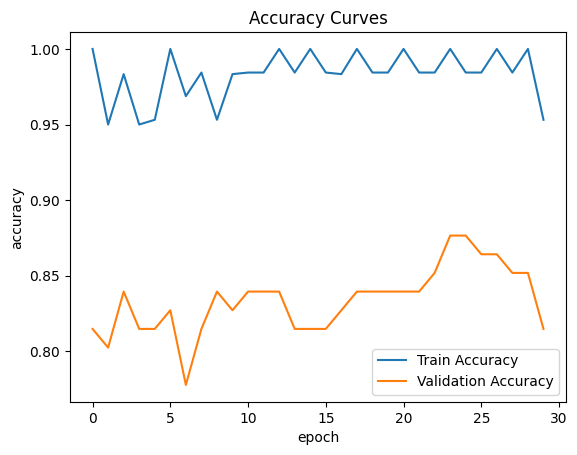

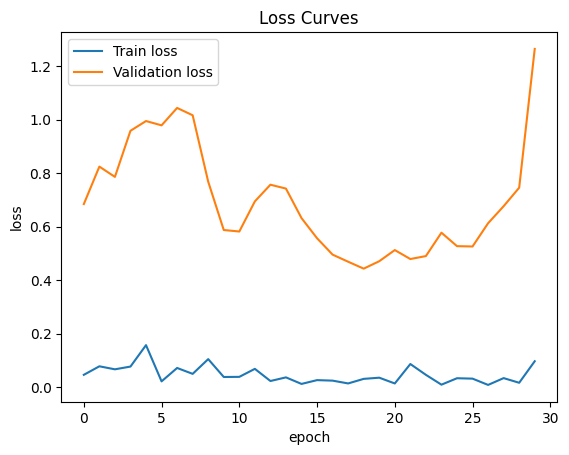

In [ ]:
loss_curve_plot(model_history)

In [ ]:
labels=test_datagen.classes
y_pred=model.predict(test_datagen)
prediction=tf.math.round(y_pred).numpy()
prediction=prediction.argmax(axis=1)

supervised_metrics(labels, prediction)

In [ ]:
model_base = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
)
model_base.trainable = True

for layers in model_base.layers[:-30]:
    layers.trainable=False

#Transfer Learning Model
inputs=tf.keras.Input(shape=(224,224,3))
x=model_base(inputs)
x=lyrs.GlobalAveragePooling2D()(x)
x= lyrs.Dropout(0.5)(x)
outputs=lyrs.Dense(2, activation="softmax",
                     kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                              

In [ ]:
# checkpointer = ModelCheckpoint('model.hdf5',verbose=1, save_best_only= True)
# early_stopping = EarlyStopping(monitor= 'val_loss', patience= 3)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])
model_history=model.fit(x=train_datagen,
         steps_per_epoch=8,
         validation_data=test_datagen,
         epochs=30,
        #  callbacks=[checkpointer, early_stopping]
                        )

Epoch 1/30
8/8 [==============================] - 6s 269ms/step - loss: 0.7243 - accuracy: 0.6719 - val_loss: 0.5997 - val_accuracy: 0.7037
Epoch 2/30
8/8 [==============================] - 0s 54ms/step - loss: 0.5832 - accuracy: 0.7188 - val_loss: 0.5338 - val_accuracy: 0.7407
Epoch 3/30
8/8 [==============================] - 1s 64ms/step - loss: 0.5634 - accuracy: 0.8000 - val_loss: 0.5500 - val_accuracy: 0.7160
Epoch 4/30
8/8 [==============================] - 0s 46ms/step - loss: 0.4605 - accuracy: 0.7812 - val_loss: 0.6482 - val_accuracy: 0.5926
Epoch 5/30
8/8 [==============================] - 0s 66ms/step - loss: 0.5296 - accuracy: 0.7833 - val_loss: 0.6475 - val_accuracy: 0.5679
Epoch 6/30
8/8 [==============================] - 0s 44ms/step - loss: 0.4567 - accuracy: 0.8000 - val_loss: 0.6372 - val_accuracy: 0.5802
Epoch 7/30
8/8 [==============================] - 0s 65ms/step - loss: 0.3330 - accuracy: 0.8594 - val_loss: 0.5959 - val_accuracy: 0.6296
Epoch 8/30
8/8 [==========

In [ ]:
labels=test_datagen.classes
y_pred=model.predict(test_datagen)
prediction=tf.math.round(y_pred).numpy()
prediction=prediction.argmax(axis=1)

supervised_metrics(labels, prediction)